<a href="https://colab.research.google.com/github/aditirajesh/Facial-Recognition-using-Siamese-Networks/blob/main/SimilarityPrediction_augments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install joblib

In [2]:
from __future__ import division, print_function
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import models
import torchvision.datasets as datasets
from PIL import Image
import os
import requests
import urllib
from io import BytesIO
import itertools
import numpy as np
import cv2


from sklearn.ensemble import RandomForestClassifier
import joblib
from sklearn.model_selection import train_test_split, KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
!wget https://github.com/maticvl/dataHacker/raw/master/DATA/at%26t.zip
!rm -rf data
!unzip "at&t.zip" -d .

In [4]:
training_dir = "./data/faces/training"

In [ ]:
inception_v3= models.inception_v3(pretrained=True)
inception_v3.eval()

In [6]:
def get_image_triples(image_dir):
  image_groups = {} #segregating images acc to similarity groups
  for root,_,files in os.walk(image_dir):
    if files != ['README']:
      for file in files:
        if file.endswith(".pgm"):
          group_name = os.path.basename(root) #group name which they belong to
          if group_name not in image_groups:
            image_groups[group_name] = []
          image_groups[group_name].append(os.path.join(root, file))

  num_sims = 0
  image_triples = []
  group_list = sorted(list(image_groups.keys())) #list of all similarity groups in sorted order
  for index,group in enumerate(group_list):
    images_in_group = image_groups[group]
    all_sim_pairs = itertools.combinations(images_in_group,2) #all possible similarity combinations

    for ref_image, sim_image in all_sim_pairs:
      image_triples.append((ref_image,sim_image,1)) #reference image, similar image, label.
      num_sims += 1

      while True:
        dissimilar_idx = np.random.randint(low=0,high=len(group_list),size=1)[0]
        if dissimilar_idx != index:
          break

      dissimilar_images = image_groups[group_list[dissimilar_idx]]
      rand_idx = np.random.randint(low=0,high=len(dissimilar_images),size=1)[0]
      dissimilar_image = dissimilar_images[rand_idx]
      image_triples.append((ref_image,dissimilar_image,0)) #reference image, dissimilar image, label
      #if label = 1, similar. if label = 0, dissimilar.

  print("Generated {:d} pos + {:d} neg = {:d} total image triples"
          .format(num_sims, num_sims, 2*num_sims))
  return image_triples


In [7]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [8]:
image_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(299, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [9]:
def image_path_to_tensor(image_path, model):
    image = Image.open(image_path).convert("L")  # Open the image in grayscale
    open_cv_image = np.array(image)

    # Detect faces
    faces = face_cascade.detectMultiScale(open_cv_image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # If no faces are detected, use the whole image
    if len(faces) == 0:
        cropped_img = image
    else:
        # Crop the first detected face
        x, y, w, h = faces[0]
        cropped_img = image.crop((x, y, x+w, y+h))

    # Convert cropped grayscale image to RGB
    cropped_img_rgb = Image.merge("RGB", (cropped_img, cropped_img, cropped_img))

    # Apply transformations
    cropped_img_rgb = image_transforms(cropped_img_rgb)
    cropped_img_rgb = cropped_img_rgb.unsqueeze(0)  # Add batch dimension

    with torch.no_grad():
        vector = model(cropped_img_rgb)

    return vector.flatten().tolist()

In [10]:
def get_image_vectors(image_dir,model):
  vector_dir = {}
  for root,_,files in os.walk(image_dir):
    if files != ['README']:
      for file in files:
        if file.endswith(".pgm"):
          file_name = os.path.join(root,file)
          vector_dir[file_name] = image_path_to_tensor(file_name,model)

  return vector_dir

In [11]:
def preprocess_data(image_dir,model,train_size=0.7):
  image_triples = get_image_triples(image_dir)
  vector_dict = get_image_vectors(image_dir,model)
  xdata,ydata = [],[]
  for triple in image_triples:
    X1 = vector_dict[triple[0]]
    X2 = vector_dict[triple[1]]
    xdata.append(np.multiply(X1, X2) / (np.linalg.norm(X1, 2) * np.linalg.norm(X2, 2)))
    #xdata.append(np.abs(np.subtract(X1, X2)))
    #xdata.append(np.power(np.subtract(X1, X2), 2))
    ydata.append(triple[2])

  X, y = np.array(xdata), np.array(ydata)
  Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size)
  return Xtrain, Xtest, ytrain, ytest


In [12]:
def cross_validate(X,y,clf,k=10):
  best_score, best_clf = 0.0, None
  kfold = KFold(k)
  for kid, (train, test) in enumerate(kfold.split(X, y)):
      Xtrain, Xtest, ytrain, ytest = X[train], X[test], y[train], y[test]
      clf.fit(Xtrain, ytrain)
      ytest_ = clf.predict(Xtest)
      score = accuracy_score(ytest_, ytest)
      print("fold {:d}, score: {:.3f}".format(kid, score))
      if score > best_score:
          best_score = score
          best_clf = clf
  return best_clf, best_score

In [13]:
def test_report(clf, Xtest, ytest):
    ytest_ = clf.predict(Xtest)
    print("\nAccuracy Score: {:.3f}".format(accuracy_score(ytest_, ytest)))
    print("\nConfusion Matrix")
    print(confusion_matrix(ytest_, ytest))
    print("\nClassification Report")
    print(classification_report(ytest_, ytest))

In [14]:
def save_model(model, model_file):
    joblib.dump(model, model_file)

In [15]:
Xtrain, Xtest, ytrain, ytest = preprocess_data(training_dir,inception_v3)

Generated 1665 pos + 1665 neg = 3330 total image triples


In [107]:
clf = XGBClassifier(
    n_estimators=100,        # Number of boosting rounds
    max_depth=5,             # Maximum depth of a tree
    learning_rate=0.2,        # Step size shrinkage used in update to prevent overfitting
)

In [108]:
'''from sklearn.model_selection import RandomizedSearchCV

param_grid = {
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5, 7],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4],
    'reg_alpha': [0, 0.01, 0.05, 0.1, 1],
    'reg_lambda': [0.01, 0.1, 1, 10, 100]
}


Xtrain_subset, _, ytrain_subset, _ = train_test_split(Xtrain, ytrain, train_size=0.3, random_state=42)

# Perform RandomizedSearchCV
random_search = RandomizedSearchCV(clf, param_distributions=param_grid, n_iter=5, scoring='accuracy', cv=3, verbose=1, n_jobs=-1)
random_search.fit(Xtrain_subset, ytrain_subset)

best_clf = random_search.best_estimator_
print("Best parameters found: ", random_search.best_params_)'''

'from sklearn.model_selection import RandomizedSearchCV\n\nparam_grid = {\n    \'subsample\': [0.6, 0.7, 0.8, 0.9, 1.0],\n    \'colsample_bytree\': [0.6, 0.7, 0.8, 0.9, 1.0],\n    \'min_child_weight\': [1, 3, 5, 7],\n    \'gamma\': [0, 0.1, 0.2, 0.3, 0.4],\n    \'reg_alpha\': [0, 0.01, 0.05, 0.1, 1],\n    \'reg_lambda\': [0.01, 0.1, 1, 10, 100]\n}\n\n\nXtrain_subset, _, ytrain_subset, _ = train_test_split(Xtrain, ytrain, train_size=0.3, random_state=42)\n\n# Perform RandomizedSearchCV\nrandom_search = RandomizedSearchCV(clf, param_distributions=param_grid, n_iter=5, scoring=\'accuracy\', cv=3, verbose=1, n_jobs=-1)\nrandom_search.fit(Xtrain_subset, ytrain_subset)\n\nbest_clf = random_search.best_estimator_\nprint("Best parameters found: ", random_search.best_params_)'

In [109]:
best_clf, best_score = cross_validate(Xtrain, ytrain, clf)
test_report(best_clf, Xtest, ytest)
save_model(best_clf, 'inception_v3trained.pkl')

fold 0, score: 0.932
fold 1, score: 0.966
fold 2, score: 0.936
fold 3, score: 0.961
fold 4, score: 0.948
fold 5, score: 0.927
fold 6, score: 0.936
fold 7, score: 0.940
fold 8, score: 0.944
fold 9, score: 0.957

Accuracy Score: 0.931

Confusion Matrix
[[444  17]
 [ 52 486]]

Classification Report
              precision    recall  f1-score   support

           0       0.90      0.96      0.93       461
           1       0.97      0.90      0.93       538

    accuracy                           0.93       999
   macro avg       0.93      0.93      0.93       999
weighted avg       0.93      0.93      0.93       999



In [110]:
loaded_clf = joblib.load('inception_v3trained.pkl')


In [111]:
transform_augments = transforms.Compose([
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.Resize((299, 299)),  # Resize to match the model's input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [112]:
def image_url_to_tensor(image_url,model,augments=False):
    response = requests.get(image_url)
    image = Image.open(BytesIO(response.content)).convert("L")
    open_cv_image = np.array(image)

    # Detect faces
    faces = face_cascade.detectMultiScale(open_cv_image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # If no faces are detected, use the whole image
    if len(faces) == 0:
        cropped_img = image
    else:
        # Crop the first detected face
        x, y, w, h = faces[0]
        cropped_img = image.crop((x, y, x+w, y+h))

    # Convert cropped grayscale image to RGB
    cropped_img_rgb = Image.merge("RGB", (cropped_img, cropped_img, cropped_img))

    plt.figure()
    plt.imshow(cropped_img_rgb)
    plt.title('Cropped Image')
    plt.axis('off')
    plt.show()

    # Apply transformations
    if augments == False:
      cropped_img_rgb = image_transforms(cropped_img_rgb)

    else:
      cropped_img_rgb = transform_augments(cropped_img_rgb)
    cropped_img_rgb = cropped_img_rgb.unsqueeze(0)  # Add batch dimension

    with torch.no_grad():
        vector = model(cropped_img_rgb)

    return vector.flatten().tolist()

In [113]:
def predict_similarity(url1, url2, model, clf,augments=False):
    vector1 = image_url_to_tensor(url1, model,augments)
    vector2 = image_url_to_tensor(url2, model,augments)

    similarity_feature = np.multiply(vector1, vector2) / (np.linalg.norm(vector1, 2) * np.linalg.norm(vector2, 2) + 1e-10)  # Add epsilon to avoid division by zero
    similarity_feature = similarity_feature.reshape(1, -1)  # Reshape for prediction

    prediction = clf.predict(similarity_feature)
    return prediction[0]

####If the similarity prediction is 1 - pictures are of the same individual. If 0 - different individuals.

In [114]:
url1 = "https://d1jyxxz9imt9yb.cloudfront.net/person/1571/detail_image/mobile/LDC-High-Res-Headshot.jpg"
url2 = "https://hips.hearstapps.com/hmg-prod/images/gettyimages-908523562-sqaure.jpg?crop=1xw:1.0xh;center,top&resize=640:*"
url3 = "https://m.media-amazon.com/images/M/MV5BMjI0MTg3MzI0M15BMl5BanBnXkFtZTcwMzQyODU2Mw@@._V1_FMjpg_UX1000_.jpg"
url4 = "https://wl-brightside.cf.tsp.li/resize/728x/jpg/9b6/b68/6c70db5f149b4ec6952c412c16.jpg"
url5 = "https://d.newsweek.com/en/full/1854279/ben-cornish-leonardo-dicaprio-lookalike.jpg?w=1600&h=1200&q=88&f=7f43982b70d39858b6a1c25e1e7551c7"
url6 = "https://assets3.thrillist.com/v1/image/1656313/381x254/crop;webp=auto;jpeg_quality=60.jpg"
url7 = "https://api.ellecanada.com/app/uploads/2015/11/bebc3b03-fd93-424f-ab90-2df213a032bd-leo-throwback.jpg"
url8 = "https://media1.popsugar-assets.com/files/thumbor/U9R7VhB1GwygXfzMM0TmiUlV2Q8=/fit-in/640x640/filters:format_auto():upscale()/2015/10/29/779/n/1922398/a96fe2d39448a722_11111285_1431581643803681_1338808983_n.jpg"
url9 = "https://m.media-amazon.com/images/M/MV5BODgzMzM2NTE0Ml5BMl5BanBnXkFtZTcwMTcyMTkyOQ@@._V1_FMjpg_UX1000_.jpg"

##TESTING - WITHOUT DATA AUGMENTATION

## 1. DICAPRIO VS NYONG'O

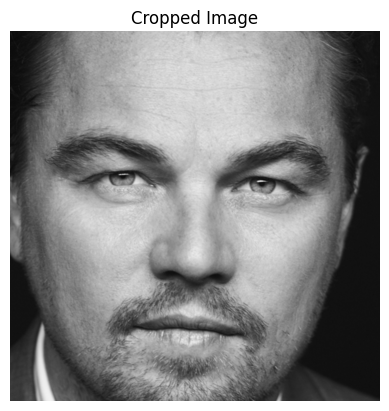

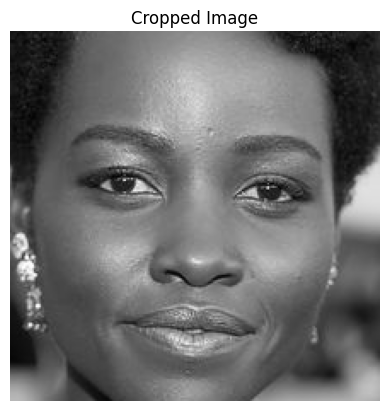

Similarity prediction: 0


In [115]:
similarity_prediction = predict_similarity(url1,url2,inception_v3, loaded_clf)
print(f'Similarity prediction: {similarity_prediction}')

## 2. CURRENT DICAPRIO VS CURRENT DICAPRIO

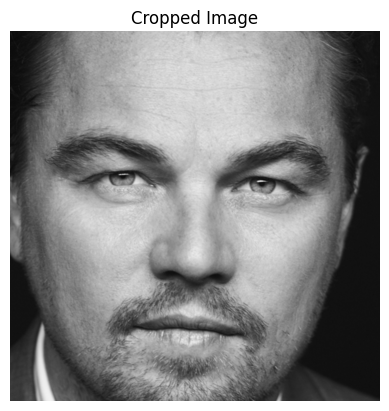

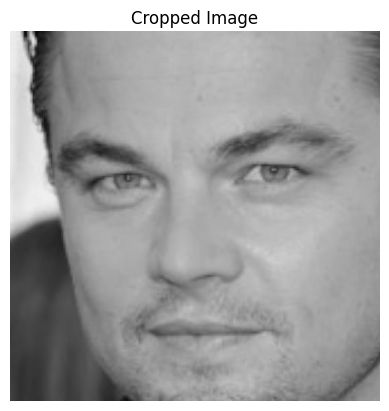

Similarity prediction: 1


In [116]:
similarity_prediction = predict_similarity(url1,url3,inception_v3, loaded_clf)
print(f'Similarity prediction: {similarity_prediction}')

## 3. CURRENT DICAPRIO VS 20s DICAPRIO


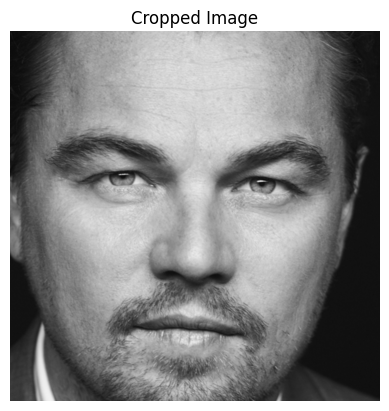

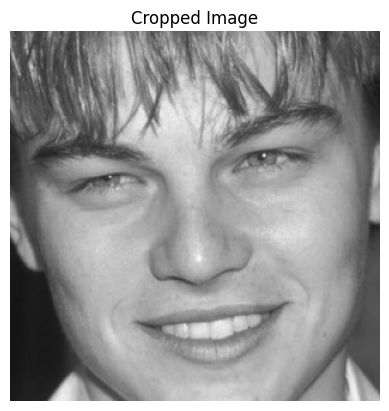

Similarity prediction: 1


In [117]:
similarity_prediction = predict_similarity(url1,url4,inception_v3, loaded_clf)
print(f'Similarity prediction: {similarity_prediction}')

## 4. DICAPRIO VS LOOK-ALIKE

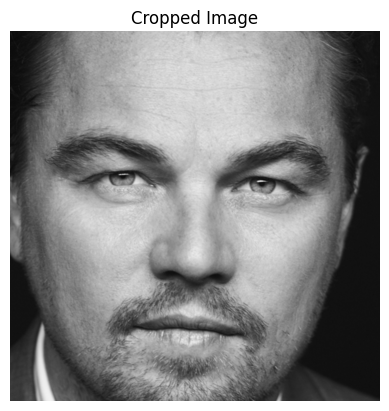

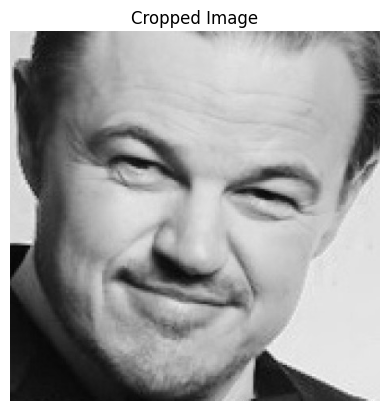

Similarity prediction: 0


In [118]:
similarity_prediction = predict_similarity(url1,url5,inception_v3, loaded_clf)
print(f'Similarity prediction: {similarity_prediction}')

## 5. CURRENT DICAPRIO VS TEENAGE DICAPRIO

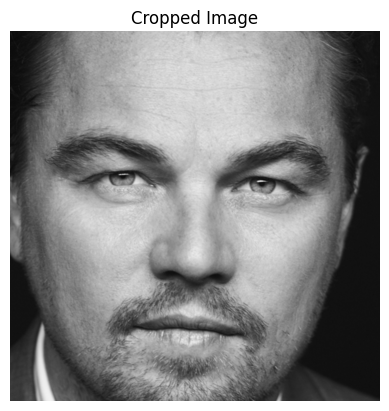

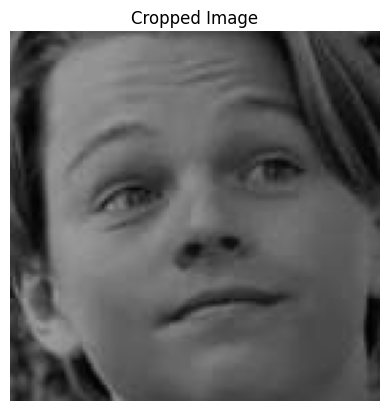

Similarity prediction: 0


In [119]:
similarity_prediction = predict_similarity(url1,url6,inception_v3, loaded_clf)
print(f'Similarity prediction: {similarity_prediction}')

Point to note: The model classifies an adolescent dicaprio and 40-50 year old dicaprio as different people.

## 6. 20s DICAPRIO VS TEENAGE DICAPRIO

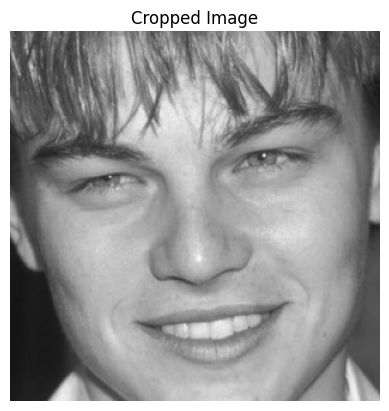

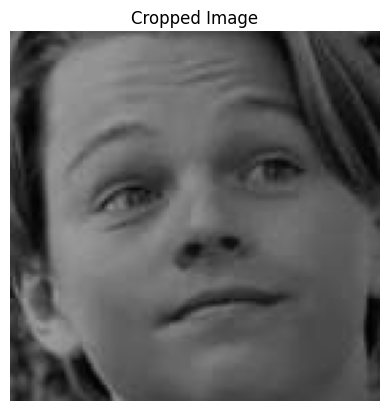

Similarity prediction: 0


In [120]:
similarity_prediction = predict_similarity(url4,url6,inception_v3, loaded_clf)
print(f'Similarity prediction: {similarity_prediction}')

The model also classifies 20s dicaprio and teenage dicaprio as different people

##7. TEENAGE DICAPRIO (CLEARER IMAGE) VS CURRENT DICAPRIO

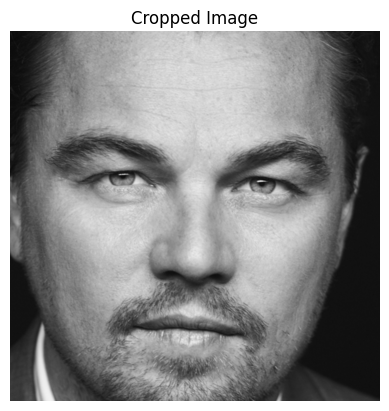

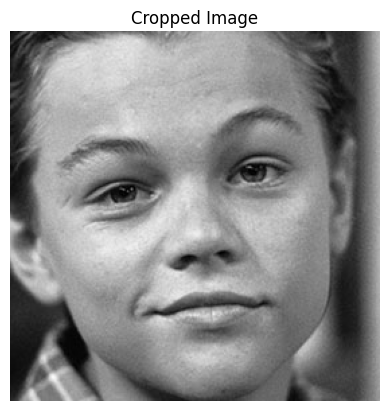

Similarity prediction: 0


In [121]:
similarity_prediction = predict_similarity(url1,url7,inception_v3, loaded_clf)
print(f'Similarity prediction: {similarity_prediction}')

##8. TEENAGE DICAPRIO (CLEARER IMAGE) VS 20S DICAPRIO

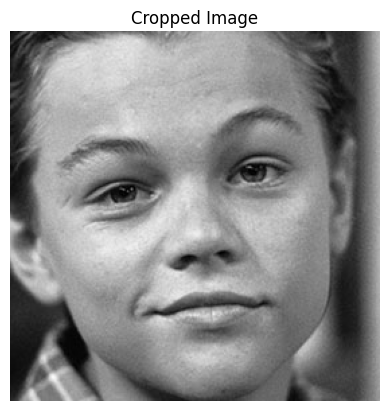

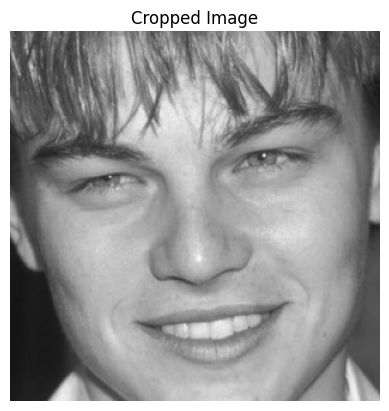

Similarity prediction: 0


In [122]:
similarity_prediction = predict_similarity(url7,url4,inception_v3, loaded_clf)
print(f'Similarity prediction: {similarity_prediction}')

## 9. TEENAGE DICAPRIO VS TEENAGE DICAPRIO

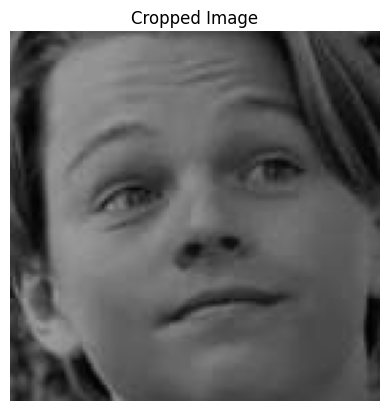

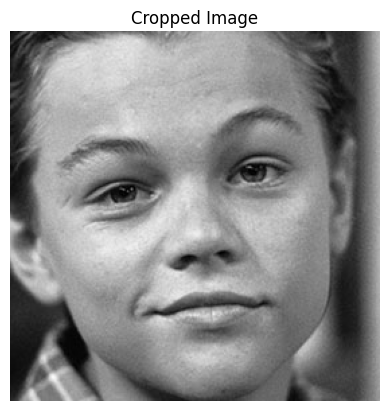

Similarity prediction: 1


In [123]:
similarity_prediction = predict_similarity(url6,url7,inception_v3, loaded_clf)
print(f'Similarity prediction: {similarity_prediction}')

##YOUNG DICAPRIO VS YOUNG DICAPRIO LOOK-ALIKE

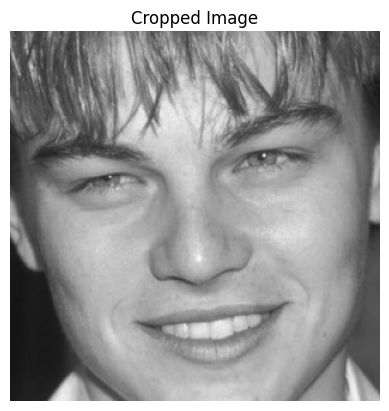

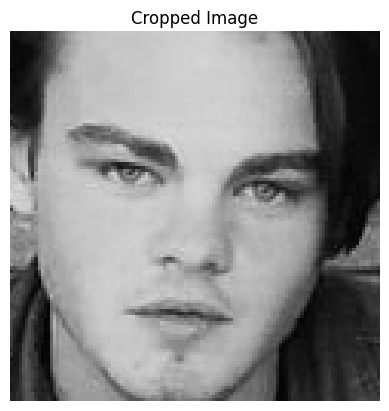

Similarity prediction: 0


In [124]:
similarity_prediction = predict_similarity(url4,url8,inception_v3, loaded_clf)
print(f'Similarity prediction: {similarity_prediction}')

##DICAPRIO VS WINSLET

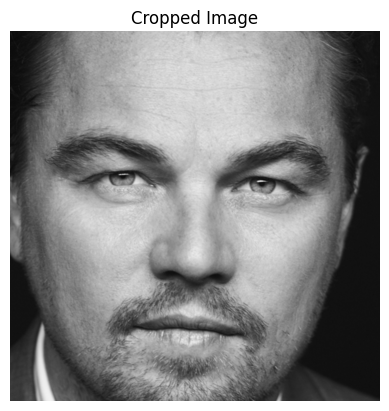

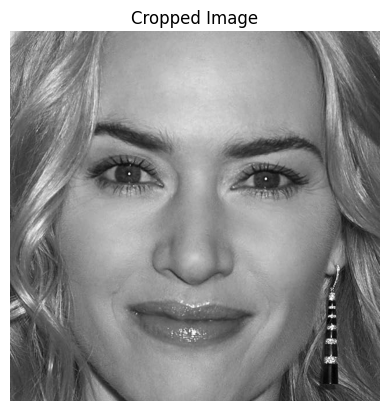

Similarity prediction: 0


In [125]:
similarity_prediction = predict_similarity(url1,url9,inception_v3, loaded_clf)
print(f'Similarity prediction: {similarity_prediction}')